In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import functools
import pathlib
import pickle
import warnings

import numpy as np
import pandas as pd
from sklearn.ensemble import (AdaBoostRegressor, BaggingRegressor, 
                              ExtraTreesRegressor, GradientBoostingRegressor,
                              RandomForestRegressor)
from sklearn.exceptions import DataConversionWarning
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor, ExtraTreeRegressor

from xgboost import XGBRegressor
from catboost import CatBoostRegressor

import src.utils.model as model

warnings.filterwarnings('ignore', category=DataConversionWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
data = pathlib.Path('..') / 'data'
npys = data / 'npys'
pkls = data / 'pkls'
models = data / 'models'

In [4]:
def merge_features(name):
    """Merge all serialized features into a single dataframe.
    
    Parameters
    ----------
    name : str
        'train' or 'valid'
    
    Returns
    -------
    df : DataFrame
        DataFrame with all the features combined.
    """
    
    def load_pickle(identifier=''):
        return pd.read_pickle(pkls / f'{name}_{identifier}.pkl')
    
    essay_df = pd.read_pickle(pkls / f'{name}.pkl')
    descr_df = pd.read_pickle(pkls / 'descr.pkl')[['essay_set', 'grade_level']]
    essay_to_grade_level = descr_df.set_index('essay_set').to_dict()['grade_level']
    
    #: features
    difficulty_level_df = load_pickle('difficulty_level')
    error_ratio_df = load_pickle('error_ratio')
    grade_level_arr = essay_df['essay_set'].map(essay_to_grade_level).values
    grade_level_df = pd.DataFrame(grade_level_arr, columns=['grade_level'])
    pos_df = load_pickle('pos')
    prompt_similarity_df = load_pickle('prompt_similarity')
    sentiment_df = load_pickle('sentiment')
    words_df = load_pickle('words')
    
    #: targets
    percent_df = essay_df[['domain1_percent', 'domain2_percent']]
    
    dfs = [difficulty_level_df, error_ratio_df, grade_level_df, pos_df, 
           prompt_similarity_df, sentiment_df, words_df, percent_df]
    return pd.concat(dfs, axis=1)

In [5]:
train_df = merge_features('train')
train_df.head()

,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,linsear_write_formula,gunning_fog,error_ratio,grade_level,...,WRB,count,tfidf,polarity,subjectivity,avg_len,sentence_count,word_count,domain1_percent,domain2_percent
0,74.02,10.4,8.5,8.48,11.3,5.88,8.666667,11.85,0.008533,8,...,0.005747,0.415474,0.297531,0.232050,0.364989,5.616766,1,167,60.0,NaN
1,67.08,11.6,9.1,7.78,9.9,6.49,10.166667,12.98,0.008741,8,...,0.020833,0.339572,0.235998,0.248889,0.625741,5.386667,1,225,70.0,NaN
2,68.20,12.0,8.7,8.24,9.8,6.66,8.142857,13.12,0.005191,8,...,0.010345,0.638644,0.529368,0.353693,0.498769,5.798561,1,139,50.0,NaN
3,53.34,13.9,12.3,11.20,15.4,7.74,16.000000,17.58,0.009795,8,...,0.007055,0.418874,0.286866,0.230774,0.466161,6.045752,1,306,80.0,NaN
4,72.66,11.3,7.0,7.83,7.5,5.83,8.714286,9.81,0.011288,8,...,0.010571,0.411188,0.297567,0.194564,0.474639,5.652174,1,230,60.0,NaN


In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 55 columns):
flesch_reading_ease             12976 non-null float64
smog_index                      12976 non-null float64
flesch_kincaid_grade            12976 non-null float64
coleman_liau_index              12976 non-null float64
automated_readability_index     12976 non-null float64
dale_chall_readability_score    12976 non-null float64
linsear_write_formula           12976 non-null float64
gunning_fog                     12976 non-null float64
error_ratio                     12976 non-null float64
grade_level                     12976 non-null int64
CC                              12976 non-null float64
CD                              12976 non-null float64
DT                              12976 non-null float64
EX                              12976 non-null float64
FW                              12976 non-null float64
IN                              12976 non-null float64
JJ           

In [7]:
valid_df = merge_features('valid')
valid_df.head()

,flesch_reading_ease,smog_index,flesch_kincaid_grade,coleman_liau_index,automated_readability_index,dale_chall_readability_score,linsear_write_formula,gunning_fog,error_ratio,grade_level,...,WRB,count,tfidf,polarity,subjectivity,avg_len,sentence_count,word_count,domain1_percent,domain2_percent
0,56.59,12.7,11.1,10.39,13.3,6.70,10.833333,14.07,0.011722,8,...,0.008368,0.565212,0.410547,0.166453,0.366880,5.898438,1,128,50.0,NaN
1,80.31,10.2,6.1,5.86,6.4,5.51,10.500000,9.23,0.008723,8,...,0.015060,0.370156,0.274027,-0.006765,0.426275,4.865385,1,156,60.0,NaN
2,64.88,11.9,12.0,7.85,14.6,6.20,12.200000,15.14,0.009390,8,...,0.004444,0.401037,0.297338,0.170603,0.361980,5.545455,1,209,70.0,NaN
3,73.17,9.9,6.8,7.30,7.1,5.47,15.250000,8.77,0.010601,8,...,0.023936,0.325612,0.227408,0.172817,0.468684,5.521505,1,186,70.0,NaN
4,74.90,10.2,6.1,7.58,6.6,5.48,6.000000,8.32,0.005562,8,...,0.004415,0.549260,0.404606,0.290172,0.585408,5.736842,1,228,70.0,NaN


In [8]:
X_train = train_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_train = train_df['domain1_percent']

X_valid = valid_df.drop(columns=['domain1_percent', 'domain2_percent'])
y_valid = valid_df['domain1_percent']

In [9]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)

In [37]:
metrics = [mean_absolute_error, mean_squared_error, r2_score]
grid_cv = functools.partial(model.grid_search_cv, X=X_train, y=y_train, n_jobs=-1)
score_est = functools.partial(model.score_estimator, 
                              metrics=metrics, 
                              X=X_train,
                              y=y_train)
plot_resid = functools.partial(model.plot_residuals, X=X_train, y=y_train)

In [11]:
def score(fit_estimator, X, y):
    pred = fit_estimator.predict(X)
    return {m.__name__: m(y, pred) for m in metrics}


def save_model(model, name):
    file = models / f'{name}.pkl'
    with open(file, 'wb') as fp:
        pickle.dump(model, fp)

# Linear Regression

In [12]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)
score(linear_reg, X_train, y_train)

{'mean_absolute_error': 14.116052992093499,
 'mean_squared_error': 333.0390309134977,
 'r2_score': 0.39298626770085665}

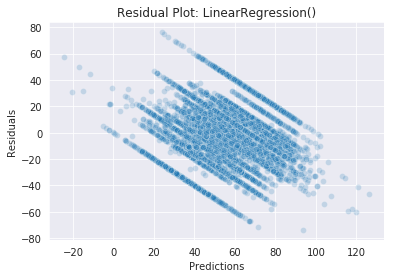

In [13]:
plot_resid(linear_reg, save_path='linear.png')

In [14]:
save_model(linear_reg, 'linear_reg')

# Lasso

In [26]:
param_grid = {'alpha': [10**i for i in range(-2, 4)], 'max_iter': [10_000], 'random_state': [0]}
lasso_best = grid_cv(Lasso(), param_grid)
lasso_best

{'alpha': 1, 'max_iter': 10000, 'random_state': 0}

In [27]:
lasso = Lasso(**lasso_best)
lasso.fit(X_train, y_train)
score(lasso, X_train, y_train)

{'mean_absolute_error': 14.672148752507129,
 'mean_squared_error': 355.9253147843486,
 'r2_score': 0.3512725726039261}

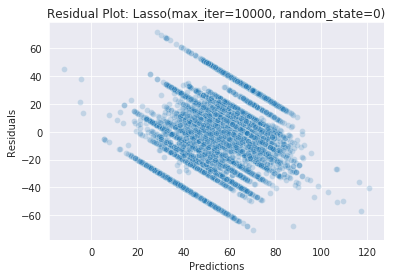

In [28]:
plot_resid(lasso, save_path='lasso.png')

In [29]:
save_model(lasso, 'lasso')

# Ridge

In [30]:
param_grid = {'alpha': [10**i for i in range(-3, 6)], 'random_state': [0]}
ridge_best = grid_cv(Ridge(), param_grid)
ridge_best

{'alpha': 10000, 'random_state': 0}

In [31]:
ridge = Ridge(**ridge_best)
ridge.fit(X_train, y_train)
score(ridge, X_train, y_train)

{'mean_absolute_error': 14.901008309595888,
 'mean_squared_error': 367.65681679528217,
 'r2_score': 0.32989014544036244}

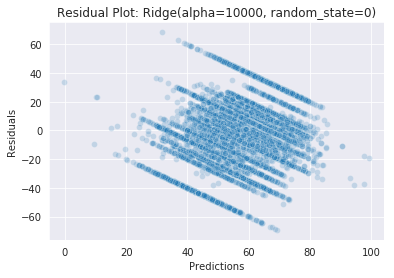

In [32]:
plot_resid(ridge, save_path='ridge.png')

In [33]:
save_model(ridge, 'ridge')

# SVM Regressor

In [36]:
from importlib import reload
reload(model);

In [54]:
param_grid = {'kernel': ['linear', 'rbf', 'sigmoid', 'poly'], 'degree': list(range(2, 5)),
              'C': [10**i for i in range(-2, 2)], 'epsilon': [10**i for i in range(-3, 1)]}
svr_best = grid_cv(SVR(), param_grid)
svr_best

/home/ubuntu/miniconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'C': 1, 'degree': 2, 'epsilon': 0.1, 'kernel': 'rbf'}

In [55]:
svr = SVR(**svr_best)
svr.fit(X_train, y_train)
score(svr, X_train, y_train)

{'mean_absolute_error': 12.334358186225979,
 'mean_squared_error': 273.4511543780627,
 'r2_score': 0.5015941363832207}

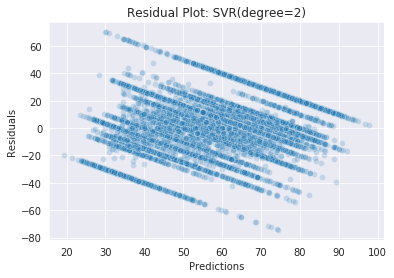

In [56]:
plot_resid(svr, save_path='svr.png')

In [57]:
save_model(svr, 'svr')

# Random Forest

In [58]:
param_grid = {'max_depth': list(range(10, 101, 10)) + [None], 'min_samples_split': list(range(2, 5)), 
              'min_samples_leaf': list(range(1, 4)), 'max_features': ['auto', 'sqrt', 'log2'], 'random_state': [0]}
randforest_best = grid_cv(RandomForestRegressor(), param_grid)
randforest_best

{'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'random_state': 0}

In [59]:
rand_forest = RandomForestRegressor(**randforest_best)
rand_forest.fit(X_train, y_train)
score(rand_forest, X_train, y_train)

{'mean_absolute_error': 10.501461336695913,
 'mean_squared_error': 191.22502440274397,
 'r2_score': 0.6514636273913085}

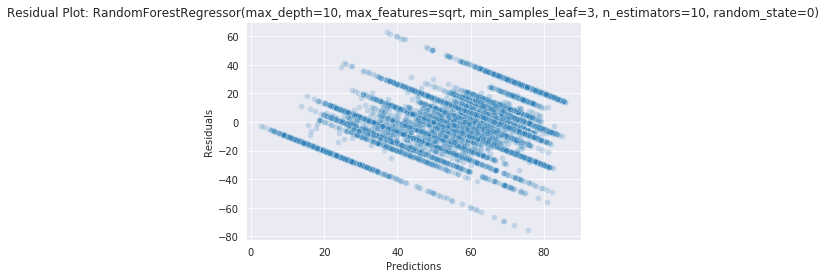

In [60]:
plot_resid(rand_forest, save_path='rand_forest.png')

In [61]:
save_model(rand_forest, 'rand_forest')

# Extra Trees

In [62]:
param_grid = {'max_depth': list(range(10, 101, 10)) + [None], 'min_samples_split': list(range(2, 5)), 
              'min_samples_leaf': list(range(1, 4)), 'max_features': ['auto', 'sqrt', 'log2'], 'random_state': [0]}
extra_trees_best = grid_cv(ExtraTreesRegressor(), param_grid)
extra_trees_best

{'max_depth': 20,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'random_state': 0}

In [63]:
extra_trees = ExtraTreesRegressor(**extra_trees_best)
extra_trees.fit(X_train, y_train)
score(extra_trees, X_train, y_train)

{'mean_absolute_error': 2.4028077837620265,
 'mean_squared_error': 12.575471700993393,
 'r2_score': 0.9770793111194677}

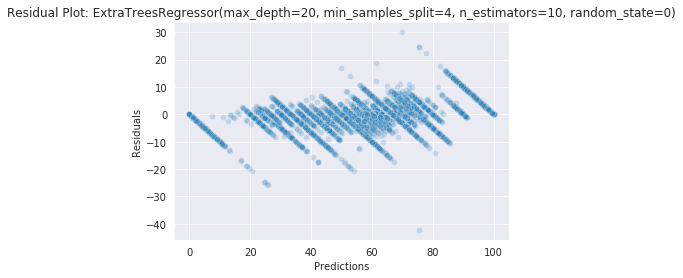

In [64]:
plot_resid(extra_trees, save_path='extra_trees.png')

In [65]:
save_model(extra_trees, 'extra_trees')

# XG Boost

In [68]:
param_grid = {'booster': ['gbtree', 'gblinear', 'dart'], 'gamma': list(np.arange(0, 0.2, 0.05)),
              'random_state': [0], 'n_jobs': [-1]}
xgboost_best = grid_cv(XGBRegressor(), param_grid)
xgboost_best

{'booster': 'gbtree', 'gamma': 0.0, 'n_jobs': -1, 'random_state': 0}

In [69]:
xgboost = XGBRegressor(**xgboost_best)
xgboost.fit(X_train, y_train)
score(xgboost, X_train, y_train)

{'mean_absolute_error': 10.836947873813523,
 'mean_squared_error': 202.94300046037134,
 'r2_score': 0.63010585331233}

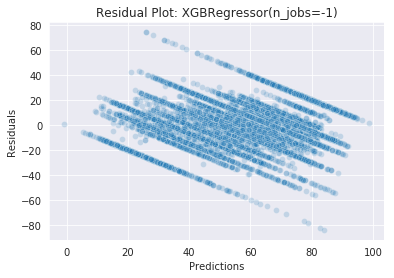

In [70]:
plot_resid(xgboost, save_path='xgboost.png')

In [71]:
save_model(xgboost, 'xgboost')

# CatBoost

In [ ]:
# param_grid = {'random_seed': 0, 'silent': True}
# catboost_best = grid_cv(CatBoostRegressor(), param_grid)
# catboost_best

In [75]:
catboost = CatBoostRegressor(random_seed=0, silent=True)
catboost.fit(X_train, y_train)
score(catboost, X_train, y_train)

{'mean_absolute_error': 9.7861010170049,
 'mean_squared_error': 168.89167847601186,
 'r2_score': 0.6921695099076273}

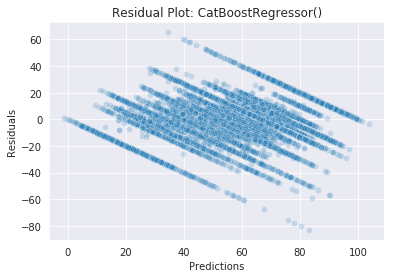

In [76]:
plot_resid(catboost, save_path='catboost.png')

In [77]:
save_model(catboost, 'catboost')

# Gradient Boosting

In [83]:
param_grid = {'loss': ['ls', 'lad', 'huber'], 'max_features': ['auto', 'sqrt', 'log2'], 
              'min_samples_split': list(range(2, 5)), 'min_samples_leaf': list(range(1, 4)),
              'alpha': list(np.arange(0.7, 0.99, 0.01)), 'random_state': [0]}
gradient_boost_best = grid_cv(GradientBoostingRegressor(), param_grid)
gradient_boost_best

{'alpha': 0.7,
 'loss': 'ls',
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'random_state': 0}

In [84]:
gradient_boost = GradientBoostingRegressor(**gradient_boost_best)
gradient_boost.fit(X_train, y_train)
score(gradient_boost, X_train, y_train)

{'mean_absolute_error': 10.820734817246063,
 'mean_squared_error': 201.95194881447347,
 'r2_score': 0.6319121940190862}

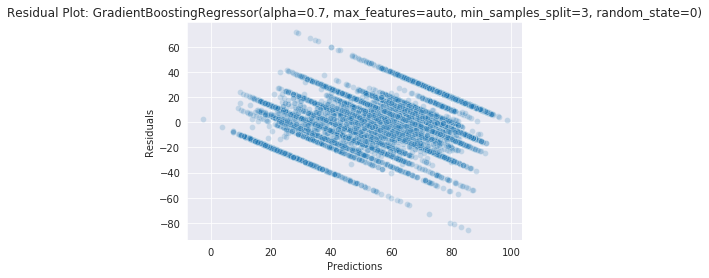

In [85]:
plot_resid(gradient_boost, save_path='gradient_boost.png')

In [86]:
save_model(gradient_boost, 'gradient_boost')